# Flower Dataset Clustering

Análisis no supervisado del conjunto de datos de flores usando histogramas de color HSV, PCA y dos algoritmos de clustering (K-Means y clustering aglomerativo).

In [1]:
from pathlib import Path

import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import rgb_to_hsv
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
)

DATA_PATH = Path('../../dataset/flowers/FlowerColorImages.h5').resolve()
OUTPUT_DIR = Path('outputs')
OUTPUT_DIR.mkdir(exist_ok=True)

In [2]:
def load_dataset(path: Path):
    with h5py.File(path, 'r') as h5_file:
        images = h5_file['images'][:]
        labels = h5_file['labels'][:]
    return images, labels


def color_histogram(hsv_image: np.ndarray, bins: int = 8) -> np.ndarray:
    hist, _ = np.histogramdd(
        hsv_image.reshape(-1, 3),
        bins=(bins, bins, bins),
        range=((0, 1), (0, 1), (0, 1)),
    )
    hist = hist.astype(np.float32)
    total = hist.sum()
    if total > 0:
        hist /= total
    return hist.ravel()


def extract_color_features(images: np.ndarray, bins: int = 8) -> np.ndarray:
    feature_length = bins ** 3 + 6  # histogram bins + mean/std por canal HSV
    features = np.zeros((images.shape[0], feature_length), dtype=np.float32)

    for idx, image in enumerate(tqdm(images, desc='Extrayendo características de color')):
        hsv = rgb_to_hsv(image.astype(np.float32) / 255.0)
        hist = color_histogram(hsv, bins=bins)
        moments = np.concatenate([hsv.mean(axis=(0, 1)), hsv.std(axis=(0, 1))])
        features[idx] = np.concatenate([hist, moments])

    return features


def reduce_with_pca(features: np.ndarray, variance_threshold: float = 0.95):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(features)

    pca = PCA(n_components=variance_threshold, random_state=42)
    embeddings = pca.fit_transform(scaled)
    return embeddings, pca


def evaluate_clustering(embeddings: np.ndarray, cluster_labels: np.ndarray, true_labels: np.ndarray):
    silhouette = silhouette_score(embeddings, cluster_labels)
    davies_bouldin = davies_bouldin_score(embeddings, cluster_labels)
    ari = adjusted_rand_score(true_labels, cluster_labels)
    nmi = normalized_mutual_info_score(true_labels, cluster_labels)

    df = pd.DataFrame({'cluster': cluster_labels, 'true': true_labels})
    majority = df.groupby('cluster')['true'].agg(lambda series: series.value_counts().idxmax()).to_dict()
    matched = np.vectorize(majority.get)(cluster_labels)
    purity = np.mean(matched == true_labels)

    return {
        'silhouette': silhouette,
        'davies_bouldin': davies_bouldin,
        'ARI': ari,
        'NMI': nmi,
        'purity': purity,
        'majority_mapping': majority,
    }


In [3]:
images, labels = load_dataset(DATA_PATH)
print(f'Imágenes cargadas: {images.shape[0]} de tamaño {images.shape[1:]}')
print(f'Etiquetas únicas: {np.unique(labels)}')

Imágenes cargadas: 210 de tamaño (128, 128, 3)
Etiquetas únicas: [0 1 2 3 4 5 6 7 8 9]


In [4]:
features = extract_color_features(images, bins=8)
print(f'Matriz de características: {features.shape}')

embeddings, pca = reduce_with_pca(features, variance_threshold=0.95)
print(f'Componentes retenidas: {embeddings.shape[1]}')
print(f'Varianza explicada: {pca.explained_variance_ratio_.sum():.2%}')

Extrayendo características de color:   0%|          | 0/210 [00:00<?, ?it/s]

Extrayendo características de color:   7%|▋         | 15/210 [00:00<00:01, 144.70it/s]

Extrayendo características de color:  16%|█▌        | 33/210 [00:00<00:01, 162.65it/s]

Extrayendo características de color:  24%|██▍       | 51/210 [00:00<00:00, 169.10it/s]

Extrayendo características de color:  32%|███▏      | 68/210 [00:00<00:00, 166.36it/s]

Extrayendo características de color:  41%|████      | 86/210 [00:00<00:00, 169.35it/s]

Extrayendo características de color:  50%|████▉     | 104/210 [00:00<00:00, 172.22it/s]

Extrayendo características de color:  58%|█████▊    | 122/210 [00:00<00:00, 172.79it/s]

Extrayendo características de color:  67%|██████▋   | 140/210 [00:00<00:00, 171.85it/s]

Extrayendo características de color:  75%|███████▌  | 158/210 [00:00<00:00, 174.17it/s]

Extrayendo características de color:  84%|████████▍ | 176/210 [00:01<00:00, 167.61it/s]

Extrayendo características de color:  92%|█████████▏| 194/210 [00:01<00:00, 169.90it/s]

Extrayendo características de color: 100%|██████████| 210/210 [00:01<00:00, 169.85it/s]

Matriz de características: (210, 518)
Componentes retenidas: 110
Varianza explicada: 95.06%


In [5]:
k = len(np.unique(labels))
print(f'Número de clusters: {k}')

kmeans = KMeans(n_clusters=k, n_init=50, random_state=42)
agglomerative = AgglomerativeClustering(n_clusters=k, linkage='ward')

kmeans_labels = kmeans.fit_predict(embeddings)
agglomerative_labels = agglomerative.fit_predict(embeddings)

kmeans_metrics = evaluate_clustering(embeddings, kmeans_labels, labels)
agglomerative_metrics = evaluate_clustering(embeddings, agglomerative_labels, labels)

metrics_df = pd.DataFrame({
    'KMeans': {k: v for k, v in kmeans_metrics.items() if k != 'majority_mapping'},
    'Agglomerative': {k: v for k, v in agglomerative_metrics.items() if k != 'majority_mapping'},
})

metrics_df.round(3)

Número de clusters: 10


,KMeans,Agglomerative
silhouette,0.049,0.055
davies_bouldin,2.217,2.227
ARI,0.250,0.255
NMI,0.473,0.491
purity,0.471,0.505


In [6]:
print('Mapeo mayoritario KMeans:')
for cluster, label in sorted(kmeans_metrics['majority_mapping'].items()):
    print(f'  Cluster {cluster} -> clase {label}')

print('\nMapeo mayoritario Aglomerativo:')
for cluster, label in sorted(agglomerative_metrics['majority_mapping'].items()):
    print(f'  Cluster {cluster} -> clase {label}')

kmeans_ct = pd.crosstab(labels, kmeans_labels, rownames=['true'], colnames=['cluster'])
agglomerative_ct = pd.crosstab(labels, agglomerative_labels, rownames=['true'], colnames=['cluster'])

kmeans_ct, agglomerative_ct

Mapeo mayoritario KMeans:
  Cluster 0 -> clase 4
  Cluster 1 -> clase 9
  Cluster 2 -> clase 8
  Cluster 3 -> clase 9
  Cluster 4 -> clase 3
  Cluster 5 -> clase 2
  Cluster 6 -> clase 6
  Cluster 7 -> clase 0
  Cluster 8 -> clase 3
  Cluster 9 -> clase 1

Mapeo mayoritario Aglomerativo:
  Cluster 0 -> clase 2
  Cluster 1 -> clase 7
  Cluster 2 -> clase 1
  Cluster 3 -> clase 4
  Cluster 4 -> clase 8
  Cluster 5 -> clase 6
  Cluster 6 -> clase 1
  Cluster 7 -> clase 3
  Cluster 8 -> clase 3
  Cluster 9 -> clase 0


(cluster   0  1   2  3   4   5  6  7  8  9
 true                                     
 0         3  1  13  0   0   0  1  3  0  0
 1         0  0  17  0   0   2  0  0  0  1
 2         0  0   0  0   0  19  0  0  0  0
 3         1  0   3  0  10   5  1  0  2  0
 4        21  0   0  0   0   0  0  0  0  0
 5         7  7  11  0   0   0  0  0  0  0
 6         3  1   2  1   1   6  9  0  0  0
 7         0  0   0  0   0  15  0  0  0  0
 8         1  1  24  0   0   0  0  0  0  0
 9         0  8   5  2   0   2  1  0  0  0,
 cluster   0  1   2   3   4  5  6  7  8  9
 true                                     
 0         0  0   5   3  10  0  0  0  0  3
 1         0  0  17   0   2  0  1  0  0  0
 2        19  0   0   0   0  0  0  0  0  0
 3         4  0   6   1   0  0  0  2  9  0
 4         0  0   0  21   0  0  0  0  0  0
 5         0  0  11  14   0  0  0  0  0  0
 6         5  0   5   4   0  9  0  0  0  0
 7         7  6   0   2   0  0  0  0  0  0
 8         0  0   5   2  19  0  0  0  0  0
 9        

Figura guardada en: /home/ruben/Documentos/GitHub/EC/src/lab5/outputs/flowers_pca_projection.png


/tmp/ipykernel_23891/1831602274.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


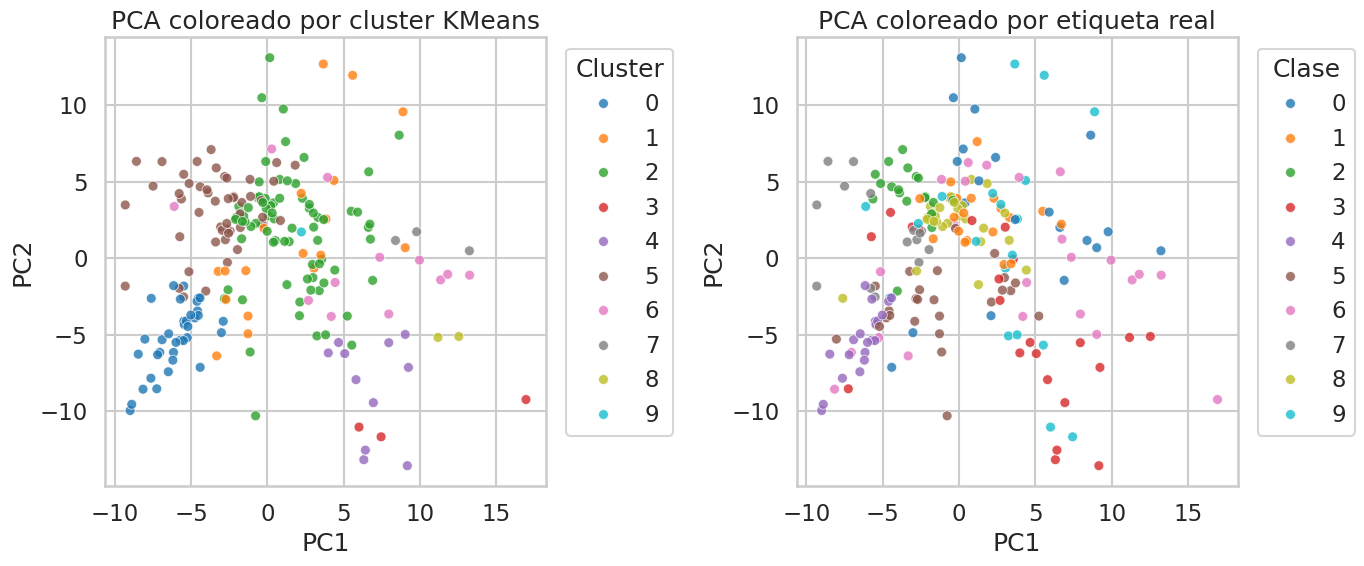

In [7]:
sns.set(style='whitegrid', context='talk')
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

plot_df = pd.DataFrame({
    'PC1': embeddings[:, 0],
    'PC2': embeddings[:, 1],
    'kmeans_cluster': kmeans_labels,
    'true_label': labels,
})

sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='kmeans_cluster', palette='tab10', s=50, alpha=0.8, ax=axes[0])
axes[0].set_title('PCA coloreado por cluster KMeans')
axes[0].legend(title='Cluster', bbox_to_anchor=(1.02, 1), loc='upper left')

sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='true_label', palette='tab10', s=50, alpha=0.8, ax=axes[1])
axes[1].set_title('PCA coloreado por etiqueta real')
axes[1].legend(title='Clase', bbox_to_anchor=(1.02, 1), loc='upper left')

fig.tight_layout()
plot_path = OUTPUT_DIR / 'flowers_pca_projection.png'
fig.savefig(plot_path, dpi=200)
print(f'Figura guardada en: {plot_path.resolve()}')
fig.show()